In [6]:
from known_boundary.GP import optimise,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [2]:
from known_boundary.GP import optimise,optimise_warp,optimise_warp_no_boundary
from known_boundary.utlis import Trans_function, get_initial_points,transform
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [12]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

##################### GP acquisition function ########################################################
def EI(X,dim,f_best,model,f_star='no'): # X is a 2-dimensional array because we will use it in scipy.minimize

  X = X.reshape(-1,dim)

  mean,var = model._raw_predict(X,include_likelihood=False) #exclude noise
  
  var[var<10**(-12)]=10**(-12)

  # z = (f_best - mean)/np.sqrt(var)        
  # out=(f_best - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  if f_star == 'no':
      z = (f_best - mean)/np.sqrt(var)        
      out=(f_best - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)
  else:
      z = (f_best - mean)/np.sqrt(var)        
      out1=(f_best - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)
      
      z = (f_star - mean)/np.sqrt(var)        
      out2=(f_star - mean) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)
      
      part3 = (f_best-f_star)*norm.cdf((f_star - mean)/np.sqrt(var)  )
      
      out = out1 - out2 + part3
    
  
  return out.ravel()  #make the shape to be 1 dimensional



def EI_acquisition_opt(model,bounds,f_best,f_star='no'): #bound should an array of size dim*2
  dim = bounds.shape[0]
  opts ={'maxiter':50*dim,'maxfun':50*dim,'disp': False}

  restart_num = 3*dim
  X_candidate = []
  AF_candidate = []

  for i in range(restart_num):
    init_X = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(30*dim, dim))
    value_holder = EI(init_X,dim,f_best,model,f_star)
      
    x0=init_X[np.argmax(value_holder)]

    res = minimize(lambda x: -EI(X=x,dim=dim,f_best=f_best,model=model,f_star=f_star),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) #L-BFGS-B  nelder-mead(better for rough function) Powell

    X_temp =  res.x  
    AF_temp = EI(X=np.array(X_temp).reshape(-1,1),dim=dim,f_best=f_best,model=model,f_star=f_star)
    
    X_candidate.append(X_temp)
    AF_candidate.append(AF_temp)

  X_next = X_candidate[np.argmax(AF_candidate)]

  return X_next

In [3]:
class GP_ObjectiveFunction2:  
    def __init__(self,X_history,Y_history,dim=2,lengthscale=0.1,variance=2,seed=0):
      
      self.dim = dim
      self.lengthscale = lengthscale
      self.variance = variance
      self.bounds = torch.tensor([[0.,1.]]*dim).T
      self.npbounds = np.array([[0.,1.]]*dim)
      self.seed =seed
      
      self.X_history = X_history.numpy()
      self.Y_history = Y_history.numpy()
      
      np.random.seed(self.seed) 

      kernel = GPy.kern.RBF(input_dim=dim,variance=self.variance,lengthscale=self.lengthscale)
      model = GPy.models.GPRegression(self.X_history.reshape(-1,dim),self.Y_history.reshape(-1,1),kernel)
      model.Gaussian_noise.variance.fix(10**(-6))
      
      self.GP = model
      
      #model.plot(plot_limits=[0,1],ls='--',color='r')
      
      
    def __call__(self, X):
        
        np.random.seed(self.seed) 

        X = X.numpy()

        Y = self.GP.posterior_samples_f(X,size=1).reshape(-1,1)

        return torch.tensor(Y)

In [36]:
seed = 1
np.random.seed(seed) 
dim = 1
f1 = GP_ObjectiveFunction2(X_history=torch.tensor([0]).reshape(-1,dim),Y_history=torch.tensor([0]).reshape(-1,1),dim=dim,seed=seed)

In [37]:
#X1 = torch.tensor([[0.1],[0.2],[0.3],[0.45],[0.5],[0.6],[0.7],[0.81],[0.96]]).reshape(-1,dim)
X1 = torch.tensor([[0.1],[0.2],[0.5],[0.96]]).reshape(-1,dim)
Y1 = f1(X1)

In [38]:
X_history = torch.cat((X1, torch.tensor([0.]).reshape(-1,dim)), dim=0)
Y_history = torch.cat((Y1, torch.tensor([0]).reshape(-1,1)), dim=0)

In [39]:
X2 = torch.tensor([[0.3]]).reshape(-1,dim)
Y2 = f1(X2)

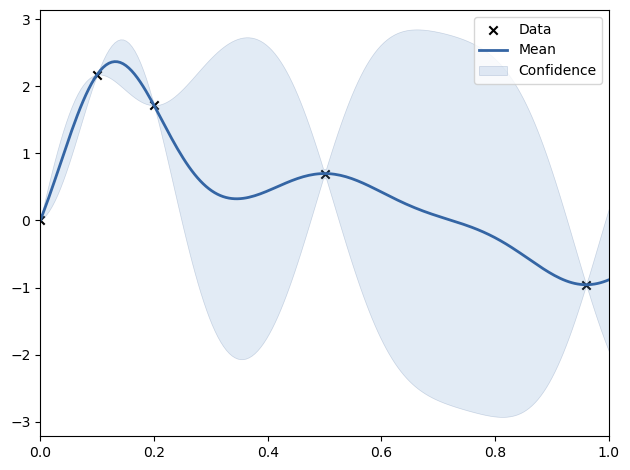

In [22]:
f2 = GP_ObjectiveFunction2(X_history=X_history.reshape(-1,dim),Y_history=Y_history.reshape(-1,1),dim=dim,seed=seed)
X2 = torch.tensor(np.linspace(0,1,50)).reshape(-1,dim)
Y2 = f2(X2)

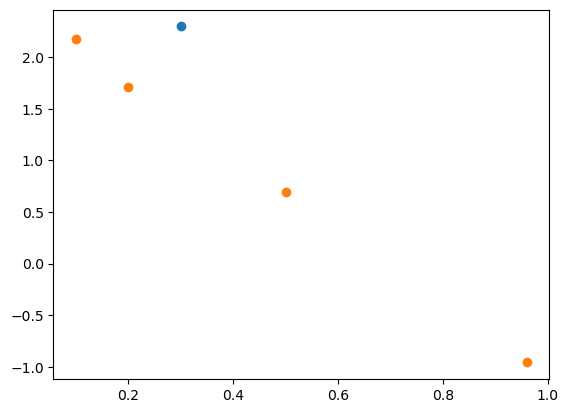

In [40]:
plt.scatter(X2,Y2.reshape(-1,1))
plt.scatter(X1,Y1.reshape(-1,1))

check

In [41]:
seed = 1
np.random.seed(seed) 
dim = 1
f1 = GP_ObjectiveFunction2(X_history=torch.tensor([0]).reshape(-1,dim),Y_history=torch.tensor([0]).reshape(-1,1),dim=dim,seed=seed)

In [42]:
X1 = torch.tensor([[0.1],[0.2],[0.5],[0.96]]).reshape(-1,dim)
Y1 = f1(X1)

In [43]:
X_history = torch.cat((X1, torch.tensor([0.]).reshape(-1,dim)), dim=0)
Y_history = torch.cat((Y1, torch.tensor([0]).reshape(-1,1)), dim=0)

Text(0.5, 1.0, 'pick X=0.3')

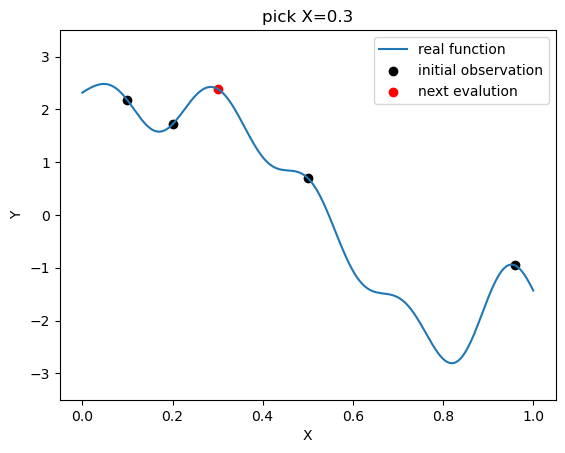

In [56]:
f2 = GP_ObjectiveFunction2(X_history=X_history.reshape(-1,dim),Y_history=Y_history.reshape(-1,1),dim=dim,seed=seed)
X2 = torch.tensor([[0.3]]).reshape(-1,dim)
Y2 = f2(X2)

X_history = torch.cat((X1, X2), dim=0)
Y_history = torch.cat((Y1, Y2), dim=0)

f3 = GP_ObjectiveFunction2(X_history=X_history.reshape(-1,dim),Y_history=Y_history.reshape(-1,1),dim=dim,seed=seed)
X3 = torch.tensor(np.linspace(0,1,200)).reshape(-1,dim)
Y3 = f3(X3)

plt.plot(X3,Y3,label = 'real function')
plt.scatter(X1,Y1,color='black',label='initial observation')
plt.scatter(X2,Y2,color='r',label = 'next evalution')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim([-3.5,3.5])

plt.legend()
plt.title('pick X=0.3')

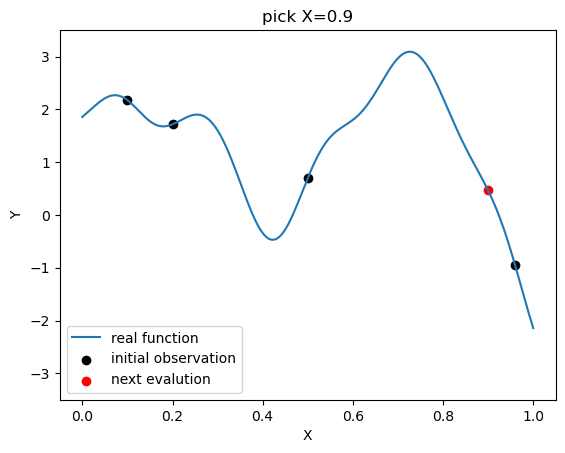

In [57]:
f2 = GP_ObjectiveFunction2(X_history=X_history.reshape(-1,dim),Y_history=Y_history.reshape(-1,1),dim=dim,seed=seed)
X2 = torch.tensor([[0.9]]).reshape(-1,dim)
Y2 = f2(X2)

X_history = torch.cat((X1, X2), dim=0)
Y_history = torch.cat((Y1, Y2), dim=0)

f3 = GP_ObjectiveFunction2(X_history=X_history.reshape(-1,dim),Y_history=Y_history.reshape(-1,1),dim=dim,seed=seed)
X3 = torch.tensor(np.linspace(0,1,200)).reshape(-1,dim)
Y3 = f3(X3)

plt.plot(X3,Y3,label = 'real function')
plt.scatter(X1,Y1,color='black',label='initial observation')
plt.scatter(X2,Y2,color='r',label = 'next evalution')
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim([-3.5,3.5])

plt.title('pick X=0.9')
plt.legend()

In [24]:
np.random.seed(0)
kernel = GPy.kern.RBF(input_dim=1)
m = GPy.models.GPRegression(X1.numpy().reshape(-1,dim),Y1.numpy().reshape(-1,1),kernel)
m.Gaussian_noise.variance.fix(10**(-6))
m.optimize_restarts(num_restarts = 1)
m

Optimization restart 1/1, f = 5.33630788012251


GP_regression.,value,constraints,priors
rbf.variance,3.63033183504184,+ve,
rbf.lengthscale,0.4306769164568437,+ve,
Gaussian_noise.variance,1e-06,+ve fixed,


In [25]:
np.random.seed(0)
res = optimise(X1.numpy(), Y1.numpy().reshape(-1,1))
print('lengthscale is: ', np.sqrt(res[0]))
print('variance is: ',res[1])

lengthscale is:  0.4306744229491541
variance is:  3.6303043563410218


# GP

In [4]:
def high_dimensional_discretization(bounds,N=800): #bounds shoud always be two dimensional, N is the number of partition in one dimension

  dim = bounds.shape[0]


  bounds = bounds.reshape(dim,-1)
  coords = [np.linspace(bounds[d][0], bounds[d][1], N) for d in range(dim)]
  mesh = np.meshgrid(*coords, indexing='ij')

  coords = np.vstack([x.flatten() for x in mesh]).T

  return coords

In [107]:
dim = 2
fun = GP_ObjectiveFunction2(X_history=torch.tensor([0.,0.]).reshape(-1,dim),Y_history=torch.tensor([0]).reshape(-1,1),dim=dim,seed=0)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

minimal output is  tensor(-5.1029, dtype=torch.float64)


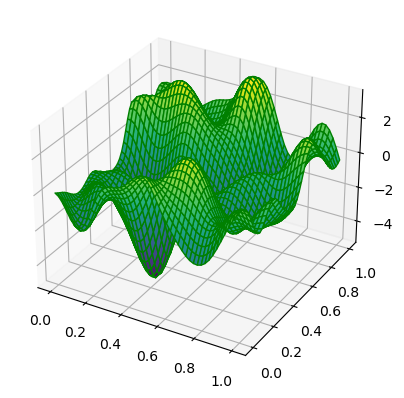

In [108]:
X_total = torch.tensor(high_dimensional_discretization(np.array([[0,1],[0,1]]),N=50))
Y_total = fun(X_total).reshape(50,50)

print('minimal output is ',Y_total.min())

X1 = np.linspace(0,1,50)
X2 = np.linspace(0,1,50)

X1X2, X2X1 = np.meshgrid(X1,X2)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1X2, X2X1, Y_total, cmap ='viridis', edgecolor ='green')

plt.show()

In [16]:
dim = 1
fun = GP_ObjectiveFunction2(X_history=torch.tensor([0.]).reshape(-1,dim),Y_history=torch.tensor([0]).reshape(-1,1),dim=dim,seed=0)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

minimal output is  tensor(-3.3884, dtype=torch.float64)


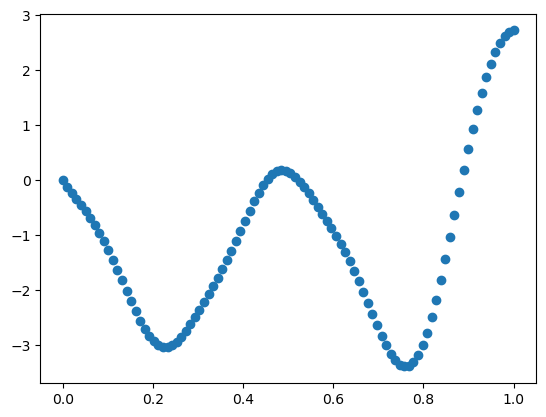

In [17]:
X_total = torch.tensor(high_dimensional_discretization(np.array([[0,1]]),N=200))
Y_total = fun(X_total)

print('minimal output is ',Y_total.min())

plt.scatter(X_total,Y_total)

In [52]:
min_holder =[]

for i in range (500):
    seed = i
    dim = 1
    Y_init = torch.tensor([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    print(Y_init)
    fun = GP_ObjectiveFunction2(X_history=torch.tensor([0.]).reshape(-1,dim),Y_history=Y_init,dim=dim,lengthscale=0.1,variance=2,seed=seed)
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    X_total = get_initial_points(bounds, 100,device,dtype,seed=seed) #torch.tensor(high_dimensional_discretization(np.array([[0,1]]),N=100))
    Y_total = fun(X_total)

    print('minimal output is ',Y_total.min())
    min_holder.append(Y_total.min())

        

tensor([[-1.5371]], dtype=torch.float64)
minimal output is  tensor(-3.0636, dtype=torch.float64)
tensor([[2.6632]], dtype=torch.float64)
minimal output is  tensor(-2.4111, dtype=torch.float64)
tensor([[-0.6323]], dtype=torch.float64)
minimal output is  tensor(-1.8549, dtype=torch.float64)
tensor([[1.6426]], dtype=torch.float64)
minimal output is  tensor(-3.0202, dtype=torch.float64)
tensor([[1.2364]], dtype=torch.float64)
minimal output is  tensor(-1.5756, dtype=torch.float64)
tensor([[1.0440]], dtype=torch.float64)
minimal output is  tensor(-2.9836, dtype=torch.float64)
tensor([[1.1207]], dtype=torch.float64)
minimal output is  tensor(-1.5832, dtype=torch.float64)
tensor([[-1.3692]], dtype=torch.float64)
minimal output is  tensor(-2.8229, dtype=torch.float64)
tensor([[-1.2226]], dtype=torch.float64)
minimal output is  tensor(-3.6051, dtype=torch.float64)
tensor([[1.2075]], dtype=torch.float64)
minimal output is  tensor(-1.1844, dtype=torch.float64)
tensor([[0.7938]], dtype=torch.float

In [53]:
np.mean(min_holder)

-2.098073119404947

In [54]:
min_holder2 =[]

for i in range (500):
    seed = i
    dim = 1
    Y_init = torch.tensor([np.random.normal(0, np.sqrt(2), size=(1,1))[0]]).reshape(-1,1)
    print(Y_init)
    fun = GP_ObjectiveFunction2(X_history=torch.tensor([0.]).reshape(-1,dim),Y_history=Y_init,dim=dim,lengthscale=0.1,variance=2,seed=seed)
    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
    
    X_3 = get_initial_points(bounds, 3,device,dtype,seed=seed) #torch.tensor(high_dimensional_discretization(np.array([[0,1]]),N=100))
    Y_3 = fun(X_3)
    
    X_history = torch.cat((X_3, torch.tensor([0.]).reshape(-1,dim)), dim=0)
    Y_history = torch.cat((Y_3, Y_init), dim=0)

    fun = GP_ObjectiveFunction2(X_history=X_history,Y_history=Y_history,dim=dim,lengthscale=0.1,variance=2,seed=seed)
    
    X_97 = get_initial_points(bounds, 97,device,dtype,seed=seed) #torch.tensor(high_dimensional_discretization(np.array([[0,1]]),N=100))
    Y_97 = fun(X_total)
    
   
    Y_total = torch.cat((Y_3, Y_97), dim=0)
    
    print('minimal output is ',Y_total.min())
    min_holder2.append(Y_total.min())

tensor([[-1.6595]], dtype=torch.float64)
minimal output is  tensor(-2.9565, dtype=torch.float64)
tensor([[2.6632]], dtype=torch.float64)
minimal output is  tensor(-4.1332, dtype=torch.float64)
tensor([[-0.6323]], dtype=torch.float64)
minimal output is  tensor(-1.9967, dtype=torch.float64)
tensor([[1.6426]], dtype=torch.float64)
minimal output is  tensor(0.0970, dtype=torch.float64)
tensor([[1.2364]], dtype=torch.float64)
minimal output is  tensor(-2.2467, dtype=torch.float64)
tensor([[1.0440]], dtype=torch.float64)
minimal output is  tensor(-3.6497, dtype=torch.float64)
tensor([[1.1207]], dtype=torch.float64)
minimal output is  tensor(-1.0051, dtype=torch.float64)
tensor([[-1.3692]], dtype=torch.float64)
minimal output is  tensor(-1.3004, dtype=torch.float64)
tensor([[-1.2226]], dtype=torch.float64)
minimal output is  tensor(-2.5983, dtype=torch.float64)
tensor([[1.2075]], dtype=torch.float64)
minimal output is  tensor(-1.1701, dtype=torch.float64)
tensor([[0.7938]], dtype=torch.float6

In [55]:
np.mean(min_holder2)

-2.0373426158196004

GP+EI (calculate minimal)

In [14]:
dim = 1
n_init = 3*dim
iter_num = 40*dim
N = 500

In [15]:
Optimial_holder = []

for exp in range(N):
    
    print(exp)

    seed = exp
    np.random.seed(seed)
    

    init_X = torch.tensor([0.]).reshape(-1,dim)
    init_Y = torch.tensor(np.random.normal(0, np.sqrt(2), size=(1,1))[0]).reshape(-1,1)
    
    fun  = GP_ObjectiveFunction2(X_history=init_X,Y_history=init_Y,dim=dim,lengthscale=0.1,variance=2,seed=seed)

    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)


    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = fun(X_BO).reshape(-1,1)
    
    # print('X_BO ',X_BO)
    # print('Y_BO ',Y_BO)

    
    X_history = torch.cat((X_BO, init_X), dim=0)
    Y_history = torch.cat((Y_BO, init_Y), dim=0)

    best_record = [Y_BO.min().item()]
    
    # plt.scatter(X_history,Y_history)
    # plt.close()

    for i in range(97):
            # update the GP function      
            fun  = GP_ObjectiveFunction2(X_history.reshape(-1,dim),Y_history.reshape(-1,1),dim=dim,lengthscale=0.1,variance=2,seed=seed)
        
            train_Y = Y_BO 
            train_X = X_BO 
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            

            lengthscale = 0.1
            variance = 2
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-6))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            #standard_next_X = get_initial_points(bounds, 1,device,dtype,seed=i)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
        #     print('X_BO ',X_BO)
        #     print('Y_BO ',Y_BO)
            
            
            best_record.append(Y_BO.min().item())
            
            #update history
            X_history = torch.cat((X_BO, init_X), dim=0)
            Y_history = torch.cat((Y_BO, init_Y), dim=0)
                        
 
            #plt.scatter(X_history,Y_history)
            
    
            
    best_record = np.array(best_record) 
    print(best_record)
    Optimial_holder.append(best_record)

0
[-2.83682246 -2.83682246 -2.83874503 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966 -2.85932966
 -2.85932966 -2.85932966 -2.85932966 -2.85932966 

In [6]:
X_BO

tensor([[0.4751],
        [0.5601],
        [0.9878],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751],
        [0.4751]], dtype=torch.float64)

random

In [11]:
np.mean(np.array(Optimial_holder)[:,0])

-1.2208121043667848

In [13]:
np.mean(np.array(Optimial_holder)[:,-1])

-1.9966723037678504

BO

In [16]:
np.mean(np.array(Optimial_holder)[:,0])

-1.2208121043667848

In [17]:
np.mean(np.array(Optimial_holder)[:,-1])

-1.8350695448811134

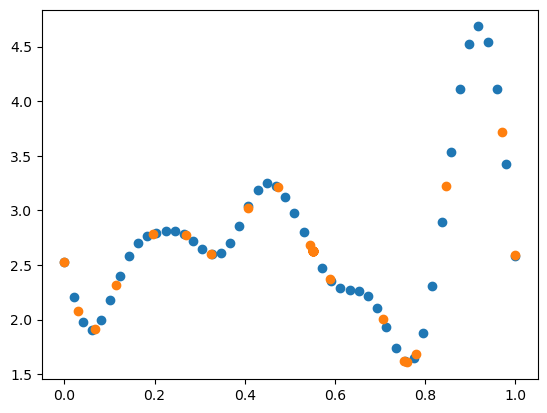

In [38]:
XX = torch.tensor(np.linspace(0,1,50)).reshape(-1,1)
YY = fun(XX)
plt.scatter(XX,YY)
plt.scatter(X_BO,Y_BO)

In [39]:
Optimial_holder = []

for exp in range(1):
    
    print(exp)

    seed = 3
    np.random.seed(seed)
    

    init_X = torch.tensor([0.]).reshape(-1,dim)
    init_Y = torch.tensor(np.random.normal(0, np.sqrt(2), size=(1,1))[0]).reshape(-1,1)
    
    fun  = GP_ObjectiveFunction2(X_history=init_X,Y_history=init_Y,dim=dim,lengthscale=0.1,variance=2,seed=seed)

    dim = fun.dim
    bounds = fun.bounds
    standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)


    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = fun(X_BO).reshape(-1,1)
    
    print('X_BO ',X_BO)
    print('Y_BO ',Y_BO)

    
    X_history = torch.cat((X_BO, init_X), dim=0)
    Y_history = torch.cat((Y_BO, init_Y), dim=0)

    best_record = [Y_BO.min().item()]

0
X_BO  tensor([[0.0685],
        [0.5890],
        [0.7590]], dtype=torch.float64)
Y_BO  tensor([[1.9175],
        [2.3700],
        [1.6068]], dtype=torch.float64)


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f858f482df0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f858f3de340>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f858f3ded00>]}

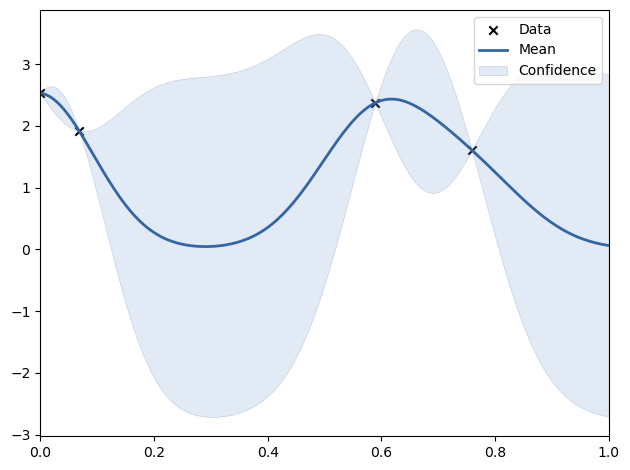

In [40]:
lengthscale = 0.1
variance = 2
kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance) 
m = GPy.models.GPRegression(X_history.numpy(), Y_history.numpy(),kernel)
m.Gaussian_noise.variance.fix(10**(-6))
m.plot(plot_limits=[0,1],ls='--',color='r')

In [13]:
X = np.array([0.1]).reshape(-1,1)
Y = np.array([2]).reshape(-1,1)
kernel = GPy.kern.RBF(input_dim=1,lengthscale= 0.5,variance=1) 
m = GPy.models.GPRegression(X, Y,kernel)
m.Gaussian_noise.variance.fix(0.1)
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.5,+ve,
Gaussian_noise.variance,0.1,+ve fixed,


In [14]:
m._raw_predict(X)

(array([[1.8181818]]), array([[0.0909091]]))

In [15]:
m.predict(X)

(array([[1.8181818]]), array([[0.1909091]]))